In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns 
import scipy.stats as stats 
import plotly.express as px 

mpl.rc('font', family='Malgun Gothic')

In [2]:
df1 = pd.read_csv('11_Data.csv')
df1.head(2)

,Unnamed: 0,Ox_Chamber,process,type,Temp_OXid,Vapor,ppm,Pressure,Oxid_time,thickness,...,Flux480s,Flux840s,input_Energy,Temp_implantation,Furance_Temp,RTA_Temp,Target,Error_message,target_binom,Chamber_Route
0,0,1,Oxidation,dry,1138.979159,O2,32.80,0.200,62.0,699.443,...,3.002593e+17,6.000007e+17,31574.410,102.847,885.0,154,96,none,0.0,route_11133
1,1,1,Oxidation,dry,1218.184551,O2,31.86,0.194,137.0,696.792,...,3.017903e+17,6.000012e+17,31580.213,104.323,919.0,154,102,none,0.0,route_11222


# Ensemble Model 

- 기존에 존재하는 여러가지 알고리즘을 결합 또는 조합하여 새로운 형태의 강력한 알고리즘을 생성 

1. Voting Model : 서로 다른 알고리즘을 결합하여 가장 좋은 성능의 알고리즘을 찾아 사용하는 기법 
    - Train Data -> 1) DT / 2) Logistic / 3) SVM ... -> Best Model 
2. Bagging Model : 학습데이터에서 서로다른 복원추출(Sub-Sampling)된 데이터를 하나의 알고리즘이 여러번 학습해나온 결과를 결합하여 하나의 강력한 모델을 구성하는 방법 
    - Sub Sampling : 1000개 Data 
        1) 700개 무작위 추출 -> DT 학습 
        2) 700개 무작위 추출 -> DT 학습
        3) 700개 무작위 추출 -> DT 학습 
        ... -> 위에서 학습된 Model을 결합 
3. **Boosting Model** : 앞서 Bagging기법과 같이 복원추출 된 데이터를 하나의 모델이 학습, 학습을 수행 할 때 마다 이전의 학습결과를 반영하여 다음 복원추출 단계에 반영해 학습
     - DT Model : 비모수데이터 잘 작동 / 과적합 

In [3]:
# 1. X/Y를 선언 한다. 
Y = df1['target_binom'] # wafer 폐기 여부를 분류하는 알고리즘을 구성 
X = df1[['type', 'UV_type','thickness','resist_target','Line_CD','Etching_rate']]

In [4]:
# 2. 지도학습에 필요한 라이브러리를 호출 
from sklearn.model_selection import train_test_split
from sklearn.compose        import make_column_transformer
from imblearn.pipeline      import make_pipeline
from sklearn.impute         import SimpleImputer, KNNImputer
from sklearn.preprocessing  import MinMaxScaler, OneHotEncoder
from imblearn.over_sampling import ADASYN
from sklearn.ensemble import RandomForestClassifier # Bagging Model 
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics   import classification_report
import pickle

In [5]:
# 3. 학습/검증 데이터 분할 
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.3,
                                                    random_state=1234)

In [6]:
# 4. 파이프라인을 구성한다
numeric_pipe = make_pipeline(KNNImputer(),MinMaxScaler())
category_pipe = make_pipeline(SimpleImputer(strategy='most_frequent'),OneHotEncoder())
numeric_list  = X.describe().columns.tolist()
category_list = X.describe(include='object').columns.tolist()

preprocess_pipe = make_column_transformer((numeric_pipe, numeric_list),
                                          (category_pipe, category_list))
model_pipe = make_pipeline(preprocess_pipe, ADASYN(), RandomForestClassifier())

In [7]:
# 5. 교차검증 및 하이퍼 파라미터 튜닝 
hyperparameter_list = {'randomforestclassifier__max_depth':range(5,11),
                      'randomforestclassifier__min_samples_leaf':range(5,11),
                      'randomforestclassifier__min_samples_split':range(5,11)}
grid_model = GridSearchCV(model_pipe, param_grid=hyperparameter_list, 
                           cv=5, n_jobs=-1,scoring='f1')
grid_model.fit(X_train, Y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('knnimputer',
                                                                                          KNNImputer()),
                                                                                         ('minmaxscaler',
                                                                                          MinMaxScaler())]),
                                                                         ['thickness',
                                                                          'resist_target',
                                                                          'Line_CD',
                                                                          'Etching_rate']),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder())]),
                                                                         ['type',
                                                                          'UV_type'])])),
                                       ('adasyn', ADASYN()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': range(5, 11),
                         'randomforestclassifier__min_samples_leaf': range(5, 11),
                         'randomforestclassifier__min_samples_split': range(5, 11)},
             scoring='f1')

In [8]:
# 6. 평가 
best_model = grid_model.best_estimator_
Y_train_pred = best_model.predict(X_train)
Y_test_pred  = best_model.predict(X_test)

In [9]:
print(classification_report(Y_train, Y_train_pred))

              precision    recall  f1-score   support

         0.0       0.99      0.90      0.95       482
         1.0       0.47      0.93      0.62        44

    accuracy                           0.90       526
   macro avg       0.73      0.92      0.78       526
weighted avg       0.95      0.90      0.92       526



In [10]:
print(classification_report(Y_test,Y_test_pred))

              precision    recall  f1-score   support

         0.0       0.96      0.85      0.90       206
         1.0       0.29      0.60      0.39        20

    accuracy                           0.83       226
   macro avg       0.62      0.73      0.64       226
weighted avg       0.90      0.83      0.86       226



- 변수 중요도 (Feature Importance) 
    - 분류를 수행함에 있어, 각 Feature가 얼마나 분류에 **기여**를 하였는가 
    - Data를 나눌때 기여도가 높은 Column 확인 
    - 회귀분석의 회귀계수의 개념과는 다르다.
    - 변수중요도가 높다 해서 Y값이 직접적으로 변하지 않는다. 

- 회귀분석  Y = 500 X1 + 200 X2 + 3 X3 + 30  

encoder_list = best_model.named_steps['columntransformer'].transformers_[1][1].named_steps['onehotencoder'].get_feature_names().tolist()

In [11]:
encoder_list = best_model.named_steps['columntransformer'].transformers_[1][1].named_steps['onehotencoder'].get_feature_names().tolist()

C:\Users\DMC CONET\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [12]:
df_importance = pd.DataFrame()
df_importance['Feature'] = pd.Series(numeric_list + encoder_list)
df_importance['Importance']= best_model['randomforestclassifier'].feature_importances_

In [13]:
df_importance

,Feature,Importance
0,thickness,0.234891
1,resist_target,0.190329
2,Line_CD,0.115393
3,Etching_rate,0.333428
4,x0_dry,0.028473
5,x0_wet,0.021493
6,x1_G,0.016105
7,x1_H,0.033531
8,x1_I,0.026357


<AxesSubplot:xlabel='Feature', ylabel='Importance'>

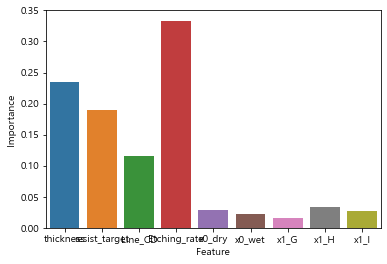

In [14]:
sns.barplot(data=df_importance, x='Feature', y='Importance')

In [15]:
# 7. 모델 파일형태로 저장
pickle.dump(best_model, open('model_best.sav','wb'))

# Boosting 
- 데이터에서 복원추출된 표본을 알고리즘이 학습하여 구성될 때 마다 오차를 줄여나가는 발향으로 학습해, 점진적으로 향상된 모델을 도출하는 방식 
- 전통적인 기계학습 모델 중에 가장 성능이 좋고 가장 많이 사용 
- Boosting Model 종류 : 
    - Ada Boosting (Adptive Boosting) : 이전에 학습의 결과에 잘 반영이 되지 않은 데이터에 대해 Weight(가중치)를 부여하여 복원추출을 수행 
        - 앞서 분류가 제대로 수행되지 못한 데이터에 대해 가중을 주며 성능 향샹
        - 데이터 이상치가 존재하는 경우, 이상치에 대해 가중을 주며 학습을 수행하므로
        지속적 학습에 대해 성능이 개선되지 않을 가능성이 존재 
        - 앞서 가중치가 너무 높게 부여가 되면, 가중치가 낮게 부여된 데이터들에 대해 오분류 될 가성이 존재 
    - Gradient Boosting : Ada boosting모델에서 이상치가 많거나 너무 높게 wieght에 대해 주변 값들이 오분류 될 가능성이 매우 높음 
        - 오분류 된 값에 가중치를 부여할 때마다, 가중치의 오차의 제곱이 최소가되는 방향으로 (최소제곱법) 가중치를 함수형태로 갱신하여 학습 
        - 가중치(함수)를 최적화하여(최소제곱법+경사하강법, Minimization) 부여 
        - Ada boosting 모델 보다 더욱 민감한 모델을 구성 
        - 시간 오래 소요 / (학습율을 잘 조절하지 못하면) 과적합 
    - XGBoosting : Gradient Boosting Model에 과적합 현상을 방지하기 위해, 규제항(Regularization)추가하여 학습을 수행 
        - Tree 구조가 복잡해지지 않도록 규제항(다양하게 선택 적용)을 추가 
        - 속도가 더 느려짐       
    - Light Boosting : boosting 계열의 모델들이 속도가 매우 저조한 현상을 개선하기 위해, 복원추출되는 데이터의 양을 조절해 학습을 수행 
        - 시간과 자원의 소요를 효과적으로 줄여주는 학습기법 
        - XGBoosting 기반으로 구성된 알고리즘 이므로, 과적합 현상도 적절하게 방지 
     - Catboosting (Categorical Boosting): 범주형 데이터로 부터 얻은 OneHotEncoding된 더미 변수들에 대해 Boosting기법을 적용하여 학습하는 기법
         - Dummy 화 된 변수를 그룹으로 분할하여 학습 및 처리 

In [16]:
!pip install --user xgboost
!pip install --user lightgbm
!pip install --user catboost

In [17]:
from lightgbm import LGBMClassifier

In [18]:
help(LGBMClassifier)

Help on class LGBMClassifier in module lightgbm.sklearn:

class LGBMClassifier(sklearn.base.ClassifierMixin, LGBMModel)
 |  LGBMClassifier(boosting_type: str = 'gbdt', num_leaves: int = 31, max_depth: int = -1, learning_rate: float = 0.1, n_estimators: int = 100, subsample_for_bin: int = 200000, objective: Union[str, Callable, NoneType] = None, class_weight: Union[Dict, str, NoneType] = None, min_split_gain: float = 0.0, min_child_weight: float = 0.001, min_child_samples: int = 20, subsample: float = 1.0, subsample_freq: int = 0, colsample_bytree: float = 1.0, reg_alpha: float = 0.0, reg_lambda: float = 0.0, random_state: Union[int, numpy.random.mtrand.RandomState, NoneType] = None, n_jobs: int = -1, silent: Union[bool, str] = 'warn', importance_type: str = 'split', **kwargs)
 |  
 |  LightGBM classifier.
 |  
 |  Method resolution order:
 |      LGBMClassifier
 |      sklearn.base.ClassifierMixin
 |      LGBMModel
 |      sklearn.base.BaseEstimator
 |      builtins.object
 |  
 |  Met

In [19]:
model_pipe = make_pipeline( preprocess_pipe, ADASYN(), LGBMClassifier() )

In [20]:
hyper_parameter = {'lgbmclassifier__max_depth':range(5,11),
                  'lgbmclassifier__n_estimators':[50, 100, 200],
                  'lgbmclassifier__learning_rate':[0.1, 0.01, 0.001]}
grid_model = GridSearchCV(model_pipe, param_grid=hyper_parameter, 
                           cv=5, n_jobs=-1,scoring='f1')
grid_model.fit(X_train, Y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('knnimputer',
                                                                                          KNNImputer()),
                                                                                         ('minmaxscaler',
                                                                                          MinMaxScaler())]),
                                                                         ['thickness',
                                                                          'resist_target',
                                                                          'Line_CD',
                                                                          'Etching_rate']),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder())]),
                                                                         ['type',
                                                                          'UV_type'])])),
                                       ('adasyn', ADASYN()),
                                       ('lgbmclassifier', LGBMClassifier())]),
             n_jobs=-1,
             param_grid={'lgbmclassifier__learning_rate': [0.1, 0.01, 0.001],
                         'lgbmclassifier__max_depth': range(5, 11),
                         'lgbmclassifier__n_estimators': [50, 100, 200]},
             scoring='f1')

In [21]:
best_model = grid_model.best_estimator_
Y_train_pred = best_model.predict(X_train)
Y_test_pred  = best_model.predict(X_test)

In [22]:
print(classification_report(Y_train, Y_train_pred))

              precision    recall  f1-score   support

         0.0       0.99      0.88      0.93       482
         1.0       0.41      0.93      0.57        44

    accuracy                           0.88       526
   macro avg       0.70      0.91      0.75       526
weighted avg       0.94      0.88      0.90       526



In [23]:
print(classification_report(Y_test, Y_test_pred))

              precision    recall  f1-score   support

         0.0       0.94      0.82      0.88       206
         1.0       0.20      0.45      0.27        20

    accuracy                           0.79       226
   macro avg       0.57      0.64      0.57       226
weighted avg       0.87      0.79      0.82       226



# Mission / 5분에 시작 ! 
- 17_Data.csv 데이터를 가져와 아래의 미션을 수행 / 엑셀 금지!

In [24]:
# 1. 데이터 재구조화 함수를 이용하여, 데이터 테이블을 아래와 같이 구성 
df_17  = pd.read_csv('17_Data.csv', encoding='cp949')
df_melt = df_17.iloc[2:].melt(id_vars=['순번','상품코드','상품명',' 합계'])
df1  = df_melt.rename(columns={'variable':'판매지역',
                               'value':'수량'}).drop(columns=' 합계')

In [25]:
# 2. 만들어진 데이터 테이블을 df1으로 선언하고 구조와 타입 및 결측값을 확인 
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73830 entries, 0 to 73829
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   순번      73830 non-null  float64
 1   상품코드    73830 non-null  float64
 2   상품명     73830 non-null  object 
 3   판매지역    73830 non-null  object 
 4   수량      73830 non-null  object 
dtypes: float64(2), object(3)
memory usage: 2.8+ MB


In [26]:
pd.read_csv('17_Data.csv', encoding='cp949').shape

(117, 646)

In [27]:
# 3. '상품명'에서 'BW'이름이 포함된 항목은 'B' / 
#    'CAT'이름이 포함된 항목은 'C' / 나머지는 'S'로 값을 변환하여 '상품구분'이라는 새로운 항목을 선언
def func1(row):
    if 'BW' in row:
        return 'B'
    elif 'CAT' in row:
        return 'C'
    return 'S'

df1['상품구분'] = df1['상품명'].apply(func1)
df1['상품구분'].value_counts()

S    50076
C    17334
B     6420
Name: 상품구분, dtype: int64

In [28]:
# 4. 'B'항목과 'C'항목의 상품 발주'수량'의 평균의 차이가 있는지 그래프로 확인 후 가설검정 수행 

In [29]:
def func2(row):
    return int(row.replace(',', ''))

df1['수량(int)'] = df1['수량'].apply(func2)
df1['수량(int)'].describe()

count    73830.000000
mean        27.483354
std        129.102559
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       3984.000000
Name: 수량(int), dtype: float64

<AxesSubplot:xlabel='상품구분', ylabel='수량(int)'>

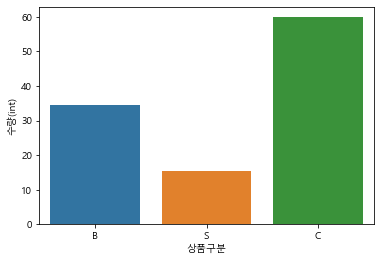

In [30]:
sns.barplot(data=df1, x='상품구분', y='수량(int)', ci=None)

<AxesSubplot:xlabel='상품구분', ylabel='수량(int)'>

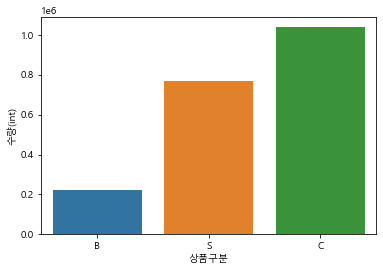

In [31]:
sns.barplot(data=df1, x='상품구분', y='수량(int)', ci=None, estimator=sum)

In [32]:
# 5. '판매지역'에서 가장 판매수량이 많은 지역 5개를 선별한 뒤,
#     5개 지역에서 가장 많이 발주된 '상품구분'항목을 확인 
p1        = df1.pivot_table(index='판매지역',values='수량(int)', aggfunc='sum')
top5_list = p1.sort_values(by='수량(int)',ascending=False).head(5).index.tolist()

In [33]:
cond1 = df1['판매지역'].isin(top5_list)
df1.loc[cond1].sort_values(by='수량(int)',ascending=False).head(5)

,순번,상품코드,상품명,판매지역,수량,상품구분,수량(int)
53462,103.0,8.801860e+12,CAT2 500ml(신),(610)부천점,"3,984",C,3984
61167,103.0,8.801860e+12,CAT2 500ml(신),(966)성남점,"2,952",C,2952
53225,96.0,8.801860e+12,CAT1 1.0L,(600)안양점,"2,637",C,2637
57239,85.0,8.801020e+12,HGD3 500ml 캔 (202006),(930)죽전점,"2,302",S,2302
61155,91.0,8.801860e+12,CAT2 500ml,(966)성남점,"2,245",C,2245


In [34]:
# 6. '판매지역'에 'E/T'값이 포함된 항목과 '
#     NB'값이 포함된 항목을 구분하여, 두 항목간 발주수량의 평균의 차이가 있는지 검정 
def func3(row):
    if 'E/T' in row:
        return 'E/T'
    elif 'NB' in row:
        return 'NB'
    else :
        return 'Other'

df1['판매지역구분'] = df1['판매지역'].apply(func3)

In [35]:
cond1 = (df1['판매지역구분'].isin(['E/T','NB']))
df2 = df1.loc[cond1]

In [36]:
# (범주형 VS 연속형 -> 평균검정)
# 6-1. 수량 데이터의 분포가 정규분포를 따르는가? (귀무: 정규분포 / 대립 : 정규분포X)
stats.normaltest(df2['수량(int)'])
# P.value < 0.05 / 대립가설 참 / 정규분포 X 

NormaltestResult(statistic=68286.2778925072, pvalue=0.0)

In [38]:
cond1  = (df2['판매지역구분'].isin(['E/T']))
cond2  = (df2['판매지역구분']=='NB')
df2_ET = df2.loc[cond1]
df2_NB = df2.loc[cond2]

In [39]:
# 6-2. 정규분포를 따르지 않는 수량값의 평균의 차이가 두집단에 따라 발생하는가? 
# 귀무가설 : 두 집단의 수량 데이터 평균의 차이가 없다.  
# 대립가설 : 두 집단의 수량 데이터 평균의 차이가 있다.
stats.ranksums(df2_ET['수량(int)'], df2_NB['수량(int)'])
# P.value < 0.05 / 대립가설 참 /두 집단의 수량 데이터 평균의 차이가 있다.

RanksumsResult(statistic=8.936132156072583, pvalue=4.030299153195065e-19)

In [40]:
# 7. '판매지역'에 따른 '수량'의 '평균'/'합'/'최대'/'최소'값을 계산 
df1.pivot_table(index='판매지역',values='수량(int)',
                aggfunc=['mean','sum','max','min']).to_excel('result.xlsx')

In [41]:
# 8. 판매 수량이 가장 높은 상위 3개의 품목을 확인 
df1.pivot_table(index='상품명',values='수량(int)',
                aggfunc='sum').sort_values(by='수량(int)', ascending=False).head(3)

,수량(int)
상품명,
CAT2 500ml,194889
CAT2 500ml(신),163233
CAT2 1.6L,125144


# 비지도 학습 

- X(설명변수)들 간의 관계(유사성,연관성,기하거리)을 이용해서 비슷한 데이터를 묶어주거나, 유사한 데이터를 확인, 차원을 줄여주는 등의 학습 기법 
    - 1. 군집분석(Clustering) : 데이터간의 거리등을 계산하여 인접한 데이터를 묶어주는 작업 
    - 2. 연관분석(Association Analysis) : 각각의 데이터의 유사도를 계산하여, 비슷한 데이터들을 찾거나 확인 하는 분석 
    - 3. 차원축소(PCA, 주성분분석) : 여러가지 항목들을 수학적 기법을 활용해 적은 차원으로 줄여주는 방법 
    
- **Clustering(군집분석)**
    - 계층형 군집분석 : 병합 또는 분할 기법을 이용해 가까운(또는 먼)위치의 데이터를 묶어 나가며 군집을 형성 하는 기법  / 알아서 층계를 형성 -> 군집의 수가 알아서 결정 
    - 비계층형 군집분석 : 데이터 간의 거리나 데이터의 밀도를 이용해 군집을 구성  
        / 사용자가 군집수를 직접 지정 / K-mean 
    - 잠재공간 군집분석 : 잠재 공간으로 추청된 값을 이용해 군집을 구성 

In [42]:
from sklearn.cluster import AgglomerativeClustering # 병합형 계층 군집분석 

In [43]:
df1 = pd.read_csv('06_Data.csv')

In [44]:
X = df1[['Mean Radius','Mean Perimeter','Mean Area', 'Mean Texture']]

In [ ]:
cluster = AgglomerativeClustering()
cluster.fit(X)

In [ ]:
X['cluster'] = cluster.fit_predict(X)

In [ ]:
sns.pairplot(data=X, hue='cluster')

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
cluster = KMeans(n_clusters= 4)
cluster.fit(X)

In [ ]:
X['kmeans_cluster'] = cluster.fit_predict(X)
X['kmeans_cluster'].value_counts()

In [ ]:
sns.pairplot(data=X, hue='kmeans_cluster')

# 실루엣 분석 

- 실루엣 값 : 같은 군집 내 데이터가 얼마나 잘 모여있는가, 서로 다른 군집끼리 데이터가 얼마나 떨어져 있는가를 수치화 한 지표 / **참고 지표로 사용** 

In [45]:
from sklearn.metrics import silhouette_score

In [46]:
X_feature = X[['Mean Radius','Mean Perimeter','Mean Area', 'Mean Texture']]

In [47]:
silhouette_score(X_feature, X['kmeans_cluster'])

KeyError: 'kmeans_cluster'

In [ ]:
for i in [2,3,4,5]:
    cluster = KMeans(n_clusters= i )
    cluster.fit(X_feature)
    X_cluster = cluster.fit_predict(X_feature)
    print(i, '개의 군집 silhouette :', silhouette_score(X_feature, X_cluster))

# Mission1.  /  0001jmp@gmail.com

-> Store.zip 파일에 있는 1_store_member.csv 데이터와 2_store_product.csv 데이터로 아래와 같은 미션을 수행하고자 한다. 

In [ ]:
# 2) df_product 데이터에서 고객 한명 당 '총구매금액'/'총구매수량'/'방문횟수'/'주당방문횟수'/'1회방문시구매금액'을 계산하고, 계산된 Table을 df_product_m1으로 선언하시오.

In [48]:
df_product = pd.read_csv('2_store_product.csv')

In [55]:
df_member = pd.read_csv('1_store_member.csv')

In [56]:
df_product['공급주차'] = pd.to_datetime(df_product['공급일자'],
                                    format='%Y%m%d').dt.isocalendar().week
df_product['공급주차'].describe()

count    735783.000000
mean         13.565960
std           7.487991
min           1.000000
25%           7.000000
50%          14.000000
75%          20.000000
max          26.000000
Name: 공급주차, dtype: float64

In [57]:
df_product['방문횟수'] = 1 
p1 = df_product.pivot_table(index=['회원번호','공급일자'],
                       values='방문횟수',aggfunc='min').reset_index()
p2 = p1.pivot_table(index='회원번호',values='방문횟수',aggfunc='sum').reset_index()
p2['주당방문횟수']= p2['방문횟수']/26

In [58]:
p3 = df_product.pivot_table(index='회원번호', 
                       values=['구매금액','구매수량'],aggfunc='sum').reset_index()

In [59]:
df_product_m0 = pd.merge(p3, p2, on='회원번호',how='left')
df_product_m1= df_product_m0.rename(columns={'구매금액':'총구매금액',
                                             '구매수량':'총구매수량',
                                             '방문횟수':'총방문횟수'})
df_product_m1['1회방문시구매금액'] = df_product_m1['총구매금액'] / df_product_m1['총방문횟수']
df_product_m1.head()

,회원번호,총구매금액,총구매수량,총방문횟수,주당방문횟수,1회방문시구매금액
0,2101.0,1991230,382.0,86,3.307692,23153.837209
1,2102.0,2095860,472.5,79,3.038462,26529.873418
2,2103.0,8273550,1675.4,126,4.846154,65663.095238
3,2104.0,6289495,1401.8,125,4.807692,50315.960000
4,2105.0,3067930,602.0,57,2.192308,53823.333333


In [60]:
# 3) df_member데이터와 df_product_m1를 '회원번호'를 기준으로 병합하고, df1으로 선언하시오.  
df1 = pd.merge(df_member, df_product_m1, on='회원번호',how='left')
df1.head(3)

,회원번호,회원상태,성별,결혼유무,주소,생년,연령,총구매금액,총구매수량,총방문횟수,주당방문횟수,1회방문시구매금액
0,2101,정상회원,여,기혼,서울 강북구 미아동 134-,1967,51,1991230.0,382.0,86.0,3.307692,23153.837209
1,2102,정상회원,여,NaN,경기 용인시 수지구 동천동,1947,71,2095860.0,472.5,79.0,3.038462,26529.873418
2,2103,정상회원,여,기혼,경기 용인시 수지구 동천동,1972,46,8273550.0,1675.4,126.0,4.846154,65663.095238


In [61]:
# 4) df1 데이터에서 주소지('구' 기준)의 빈도수가 전체 중 50%에 해당하는 지역을 A
#     나머지 30% (빈도수의 70%)를 B / 나머지 지역을 C로 나누어 '지역등급'이라는 항목으로 선언하시오. / -> 경기 용인 ("수지") / 경기,서울이외 지역은 '기타' /

In [70]:
def func4(row):
    if '경기' in row:
        return row.split(' ')[2]
    elif '서울' in row:
        return row.split(' ')[1]
    return row 

df_address = pd.DataFrame(df_member['주소'].apply(func4).value_counts())
df_address['비율'] = (df_address['주소'] / df_address['주소'].sum())
df_address2 = df_address.sort_values(by='비율',ascending=False)
df_address2['누적비율'] = df_address2['비율'].cumsum()
df_address2

,주소,비율,누적비율
수지구,1776,0.404004,0.404004
분당구,506,0.115105,0.519108
기흥구,442,0.100546,0.619654
강남구,165,0.037534,0.657188
영통구,144,0.032757,0.689945
...,...,...,...
경북 문경시 흥덕동 776,1,0.000227,0.999090
세종 종촌동 649번지 가,1,0.000227,0.999318
재궁동,1,0.000227,0.999545
세종 어진동 세종더?센트럴,1,0.000227,0.999773


In [71]:
df1['주소구분']= df1['주소'].apply(func4)

In [72]:
cond1 = df_member['주소구분'].isin(df_address2.loc[(df_address2['누적비율']<=0.70)].index.tolist())
cond2 = df_member['주소구분'].isin(df_address2.loc[(df_address2['누적비율']<=0.50)].index.tolist())
df1['지역등급']='C'
df1.loc[cond1, '지역등급']='B'
df1.loc[cond2, '지역등급']='A'
df1['지역등급'].value_counts()

A    1776
C    1363
B    1257
Name: 지역등급, dtype: int64

In [73]:
# 5) '연령'데이터를 이용하여 25세 미만은 '20대초반' / 25세 이상~ 40세 미만을 '30대' / 40세 이상 55세 미만을 "40대" / 55세 이상은 '50대이상'으로 구분해, '연령구분'을 생성
cond1 = (df1['연령']>= 55)
cond2 = (df1['연령']>= 40)
cond3 = (df1['연령']>= 25)

df1['연령구분']='20대초반'
df1.loc[cond3,'연령구분']='30대'
df1.loc[cond2,'연령구분']='40대'
df1.loc[cond1,'연령구분']='50대이상'
df1['연령구분'].value_counts()

40대      1868
50대이상    1596
30대       928
20대초반       4
Name: 연령구분, dtype: int64

In [94]:
# 6) df_product 데이터를 이용해 회원 별 '물품대분류'의 구매수량 비율을 각 항목별 로 계산하여, df1데이터에 병합하시오. 
#    (index-> 회원번호 / columns->물품대분류 / value-> 한명의 회원이 해당 품목을 구매한 비율) 
df_product['물품대분류'].value_counts()
p1 = df_product.pivot_table(index='회원번호',values='구매수량',
                            columns='물품대분류',aggfunc='sum', 
                            margins=True, fill_value=0)

p1_category_list = p1.columns.tolist()[:-1]
for i in p1_category_list:
    p1[i+'(%)'] = p1[i] / p1['All']

In [122]:
p2 = p1[p1.columns.tolist()[18:]].reset_index().iloc[:-1]
p2['회원번호(float)'] = p2['회원번호'].astype(float)

In [124]:
df1_m = pd.merge(df1, p2, left_on='회원번호', right_on='회원번호(float)',how='left')
df1_m.head(2)

,회원번호_x,회원상태,성별,결혼유무,주소,생년,연령,총구매금액,총구매수량,총방문횟수,...,서류(%),수산(%),양념/가루(%),음료(%),잡곡(%),주곡(%),주류(%),채소(%),축산물(%),회원번호(float)
0,2101,정상회원,여,기혼,서울 강북구 미아동 134-,1967,51,1991230.0,382.0,86.0,...,0.015707,0.010471,0.039267,0.026178,0.013089,0.005236,0.0,0.308901,0.251309,2101.0
1,2102,정상회원,여,NaN,경기 용인시 수지구 동천동,1947,71,2095860.0,472.5,79.0,...,0.023280,0.050794,0.035979,0.014815,0.010582,0.033862,0.0,0.220106,0.107937,2102.0


<AxesSubplot:xlabel='성별', ylabel='1회방문시구매금액'>

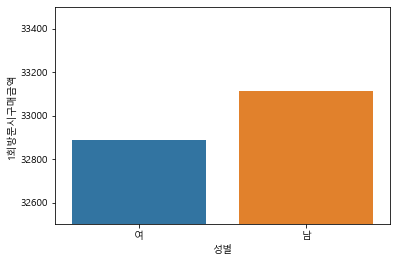

In [136]:
# 7) '성별' 에 따라 '1회방문시구매금액'의 평균의 차이가 있는지 시각화 및 검정하시오.
plt.ylim([32500,33500])
sns.barplot(data=df1_m, x='성별',y='1회방문시구매금액',ci=None)

In [137]:
df1_m.pivot_table(index='성별',values='1회방문시구매금액',aggfunc='median')

,1회방문시구매금액
성별,
남,25961.304348
여,27262.500000


In [140]:
# 7-1) '1회방문시구매금액' 데이터의 분포가 정규분포를 따르는가? 
# 귀무가설 : 1회방문시구매금액' 데이터는 정규성을 따른다. 
# 대립가설 : 1회방문시구매금액' 데이터는 정규성을 따르지 않는다.
stats.normaltest(df1_m['1회방문시구매금액'].dropna())
# P.value < 0.05 / 대립가설 참 / 정규성을 띄지 않음 

NormaltestResult(statistic=2515.0965751658086, pvalue=0.0)

In [144]:
# 7-2) 정규분포를 띄지 않는 데이터에서, 성별에 따른 1회방문시구매금액의 평균의 차이? 
# 귀무 : 집단 간 평균의 차이가 없다.
# 대립 : 집단 간 평균의 차이가 있다.
df1_m1 = df1_m[['성별','1회방문시구매금액']].dropna()

df1_man   = df1_m1.loc[(df1_m1['성별']=='남')] 
df1_woman = df1_m1.loc[(df1_m1['성별']=='여')] 
stats.ranksums(df1_man['1회방문시구매금액'], df1_woman['1회방문시구매금액'])
# P.value > 0.05 / 귀무가설 참 / 집단 간 평균의 차이가 없다. 

RanksumsResult(statistic=-1.2604454656984792, pvalue=0.20750870900597662)

In [149]:
# 8) df1 데이터에서, '총구매금액'/'총구매수량'/'방문횟수'/'주당방문횟수'/'1회방문시구매금액'데이터를 이용하여,
#     Kmeans Clustering 분석을 통해, 3군집/4군집/5군집/6군집에서 실루엣 값을 계산 하시오.
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

df1_clean = df1_m[['총구매금액','총구매수량','총방문횟수',
                   '주당방문횟수','1회방문시구매금액']].dropna()

In [150]:
for i in [3,4,5,6]:
    cluster =  KMeans(n_clusters= i )
    cluster.fit(df1_clean)
    cluster_pred = cluster.fit_predict(df1_clean)
    print(i,'군집의 실루엣 값 : ', silhouette_score(df1_clean, cluster_pred))

3 군집의 실루엣 값 :  0.8189733654004079
4 군집의 실루엣 값 :  0.7911049099097213
5 군집의 실루엣 값 :  0.7744508403735897
6 군집의 실루엣 값 :  0.7471710267850434


In [153]:
df1_clean2 = df1_m.dropna()

In [158]:
# 9) Kmeans Clustering을 통해 df1데이터를 4개 군집으로 나누고 ('총구매금액'/'총구매수량'을 활용) 각 군집을 A/B/C/D 값으로 변환해 'Target이름의 항목으로 선언 하시오. 
cluster =  KMeans(n_clusters= 4 )
cluster.fit(df1_clean2[['총구매금액','총구매수량']] )
df1_clean2['cluster'] = cluster.fit_predict(df1_clean2[['총구매금액','총구매수량']] )
df1_clean2['cluster'].value_counts()

C:\Users\DMC CONET\AppData\Local\Temp\ipykernel_12032\175110444.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1_clean2['cluster'] = cluster.fit_predict(df1_clean2[['총구매금액','총구매수량']] )


0    2788
2     380
1     161
3      24
Name: cluster, dtype: int64

In [159]:
df1_clean2['Target'] = df1_clean2['cluster'].replace({0:'A',2:'B',1:'C',3:'D'})
df1_clean2['Target'].value_counts()

C:\Users\DMC CONET\AppData\Local\Temp\ipykernel_12032\1753557468.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1_clean2['Target'] = df1_clean2['cluster'].replace({0:'A',2:'B',1:'C',3:'D'})


A    2788
B     380
C     161
D      24
Name: Target, dtype: int64

In [161]:
# 10) '성별'/'연령'/'지역등급'/'결혼유무'/'1회방문시구매금액'/'각대분류비율'을 X로, 'Target'을 분류하는 분류모델을 Ensemble 알고리즘의 RandomForestClassifier를 활용하여 분류모델을 생성, 
#     평가 후 'model_RF.sav'이름으로 저장 하시오. 
df1_clean2.columns

Index(['회원번호_x', '회원상태', '성별', '결혼유무', '주소', '생년', '연령', '총구매금액', '총구매수량',
       '총방문횟수', '주당방문횟수', '1회방문시구매금액', '주소구분', '지역등급', '연령구분', '회원번호_y',
       '간식(%)', '건강(%)', '과실(%)', '급식용(%)', '기타(%)', '반찬(%)', '베이커리(%)',
       '생활용품(%)', '서류(%)', '수산(%)', '양념/가루(%)', '음료(%)', '잡곡(%)', '주곡(%)',
       '주류(%)', '채소(%)', '축산물(%)', '회원번호(float)', 'cluster', 'Target'],
      dtype='object')

In [163]:
X = df1_clean2[['성별','결혼유무','지역등급','연령', '1회방문시구매금액',
           '간식(%)', '건강(%)', '과실(%)', '급식용(%)', '기타(%)', '반찬(%)', '베이커리(%)',
           '생활용품(%)', '서류(%)', '수산(%)', '양념/가루(%)', '음료(%)', '잡곡(%)', '주곡(%)',
           '주류(%)', '채소(%)', '축산물(%)']]
Y = df1_clean2['Target']

In [165]:
# 데이터 분할 
from sklearn.model_selection import train_test_split
# 특성 공학 + 학습 
from sklearn.compose import make_column_transformer
from imblearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE 
from sklearn.ensemble import RandomForestClassifier
# 교차검증 및 하이퍼파라미터 튜닝
from sklearn.model_selection import GridSearchCV
# 평가 및 저장 
from sklearn.metrics import classification_report
import pickle

In [166]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, random_state=1234)

In [168]:
numeric_pipe  = make_pipeline(SimpleImputer(),MinMaxScaler())
category_pipe = make_pipeline(SimpleImputer(strategy='most_frequent'),OneHotEncoder())
numeric_list   = X.describe().columns.tolist()
category_list  = X.describe(include='object').columns.tolist()
preprocess_pipe = make_column_transformer( (numeric_pipe, numeric_list),
                                           (category_pipe, category_list))
model_pipe = make_pipeline( preprocess_pipe, SMOTE(), RandomForestClassifier() )

In [169]:
hyperparameter = {}
grid_model = GridSearchCV(model_pipe, param_grid=hyperparameter, cv=5, n_jobs = -1 )
grid_model.fit(X_train, Y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('minmaxscaler',
                                                                                          MinMaxScaler())]),
                                                                         ['연령',
                                                                          '1회방문시구매금액',
                                                                          '간식(%)',
                                                                          '건강(%)',
                                                                          '과실(%)',
                                                                          '급식용(%)',
                                                                          '기타(%)',
                                                                          '반찬(%)',
                                                                          '베이커리(%)',
                                                                          '생활용품(%)',
                                                                          '서류(%)',
                                                                          '수산(%)',
                                                                          '양념/가루(%)',
                                                                          '음료(%)',
                                                                          '잡곡(%)',
                                                                          '주곡(%)',
                                                                          '주류(%)',
                                                                          '채소(%)',
                                                                          '축산물(%)']),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder())]),
                                                                         ['성별',
                                                                          '결혼유무',
                                                                          '지역등급'])])),
                                       ('smote', SMOTE()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier())]),
             n_jobs=-1, param_grid={})

In [170]:
best_model = grid_model.best_estimator_
Y_train_pred = best_model.predict(X_train)
Y_test_pred  = best_model.predict(X_test)

In [171]:
print(classification_report(Y_train, Y_train_pred))

              precision    recall  f1-score   support

           A       1.00      1.00      1.00      2091
           B       1.00      1.00      1.00       285
           C       1.00      1.00      1.00       122
           D       1.00      1.00      1.00        16

    accuracy                           1.00      2514
   macro avg       1.00      1.00      1.00      2514
weighted avg       1.00      1.00      1.00      2514



In [172]:
print(classification_report(Y_test, Y_test_pred))

              precision    recall  f1-score   support

           A       0.98      0.97      0.97       697
           B       0.65      0.77      0.71        95
           C       0.78      0.54      0.64        39
           D       1.00      0.88      0.93         8

    accuracy                           0.93       839
   macro avg       0.85      0.79      0.81       839
weighted avg       0.93      0.93      0.93       839



In [173]:
pickle.dump(best_model, open('model_RF.sav','wb'))